# Inferring chirp-like functions

In [1]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt

In [30]:
class GaussianProcessEmulator:
    def __init__(self, kernel, train_x, train_y):
        self.train_x = train_x
        self.train_y = train_y
        
        self.kernel = kernel
        
        class ExactGPModel(gpytorch.models.ExactGP):
            def __init__(self, train_x, train_y, likelihood, kernel):
                super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
                self.mean_module = gpytorch.means.ConstantMean()
                self.covar_module = kernel
            def forward(self, x):
                mean_x = self.mean_module(x)
                covar_x = self.covar_module(x)
                return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

        # initialize likelihood and model
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=gpytorch.constraints.Interval(0, .5))
        self.model = ExactGPModel(self.train_x, self.train_y, self.likelihood, self.kernel)
        
    def train(self, iterations=100):# Find optimal model hyperparameters
        self.model.train()
        self.likelihood.train()
        #test_x = torch.tensor(x[1,59000::2], dtype=torch.float32)
        #test_y = torch.tensor(y[59000::2], dtype=torch.float32)
        # Use the adam optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=.5)  # Includes GaussianLikelihood parameters

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)

        for i in range(iterations):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = self.model(self.train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, self.train_y)
            loss.backward()
            string = f'Iter {i+1}/{iterations} - Loss: {loss.item():.3f} '
            if hasattr(self.model.covar_module.base_kernel, "kernels"):
                for kernel in self.model.covar_module.base_kernel.kernels:
                    string += f" {1e7*self.kernel.lengthscale.item():.3f}E-7 "
            else:
                string += f" {self.model.covar_module.base_kernel.lengthscale.item():.3f}"
            string += f"noise: {self.model.likelihood.noise.item():.3f}"

            optimizer.step()
        print(string)
        
    def predict(self, test_x):
        self.model.eval()
        self.likelihood.eval()

        f_preds = self.model(test_x)
        y_preds = self.likelihood(self.model(test_x))

        f_mean = f_preds.mean
        f_var = f_preds.variance
        
        return f_mean, f_var, y_preds
    
    def test(self, test_x, test_y):
        """
        Perform tests on the model output
        """
        
    def test_innerproduct(self, test_x, test_y):
        """
        Calculate the inner product between the test data and the model prediction.
        """
        mean, variance, dist = self.predict(test_x)
        difference = test_y - mean.detach()
        return np.inner(difference, difference) /(np.inner(test_y, test_y))
    
    def test_mrse(self, test_x, test_y):
        """
        Calculate the MRSE between the test data and the model prediction.
        """
        mean, variance, dist = self.predict(test_x)
        difference = test_y - mean.detach()
        mrse = np.sqrt(difference**2)
        
        return mrse
        #f_covar = f_preds.covariance_matrix
        #f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

First we'll look at a simple sinusoid with a varying frequency, which is similar to what we get in the inspiral of a gravitational wave signal.

In [3]:
train_x = torch.linspace(0,10, 1000)
train_y = torch.sin(0.5*train_x**2)

findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans.


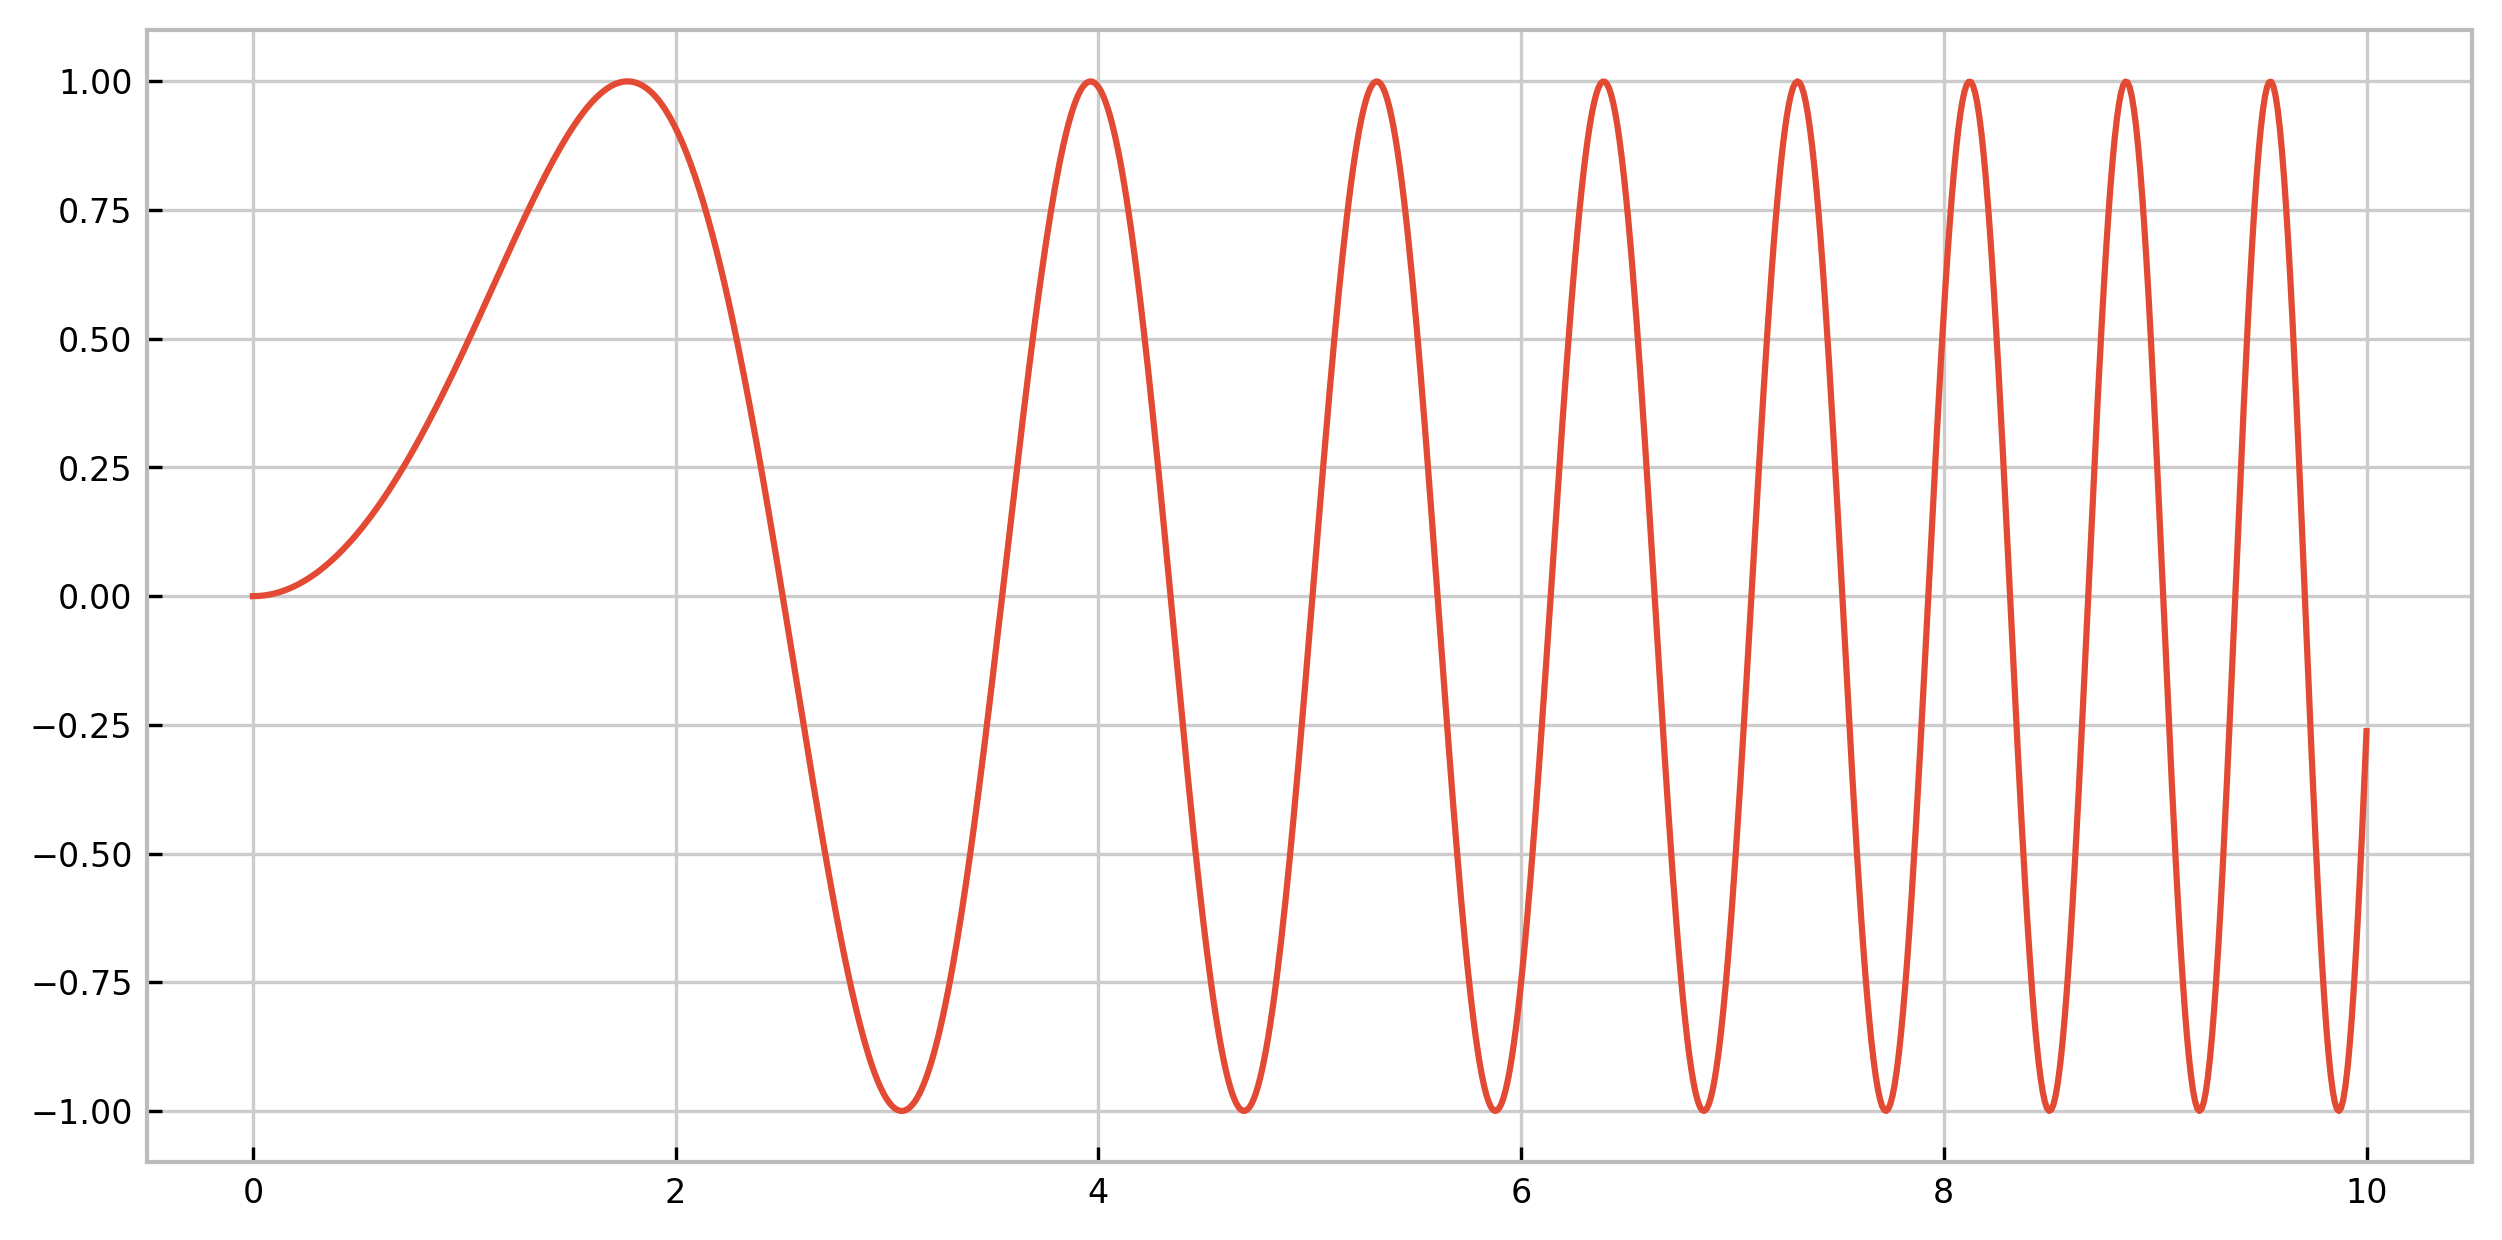

In [4]:
f, ax = plt.subplots(1,1, dpi=300, figsize=(10,5))
ax.plot(train_x, train_y)

Let's initially try a simple radial basis function to model this.

In [5]:
kernel = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel(lengthscale_constraint=gpytorch.constraints.Interval(0.1, 5)) 
)

We'll also use a simple, exact Gaussian process for such a small amount of data.

In [6]:
gp = GaussianProcessEmulator(kernel, train_x, train_y)

In [7]:
gp.train(500)

/home/daniel/repositories/heron/environment/lib/python3.9/site-packages/gpytorch/utils/linear_cg.py:266: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  _jit_linear_cg_updates_no_precond(


Iter 1/500 - Loss: 1.066  2.550noise: 0.250
Iter 11/500 - Loss: 0.514  0.168noise: 0.336
Iter 21/500 - Loss: -1.154  0.153noise: 0.008


/home/daniel/repositories/heron/environment/lib/python3.9/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1074555.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/daniel/repositories/heron/environment/lib/python3.9/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3790536.75 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 31/500 - Loss: -1.692  0.209noise: 0.000


/home/daniel/repositories/heron/environment/lib/python3.9/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3614524.25 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/daniel/repositories/heron/environment/lib/python3.9/site-packages/gpytorch/utils/linear_cg.py:321: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1884957.625 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/daniel/repositories/heron/environment/lib/python3.9/site-packages/gpytorch/utils/linear_cg.py

Iter 41/500 - Loss: -2.584  0.159noise: 0.000
Iter 51/500 - Loss: -1.783  0.170noise: 0.001
Iter 61/500 - Loss: -1.457  0.174noise: 0.002
Iter 71/500 - Loss: -1.281  0.176noise: 0.002
Iter 81/500 - Loss: -1.225  0.177noise: 0.002
Iter 91/500 - Loss: -1.187  0.177noise: 0.002
Iter 101/500 - Loss: -1.175  0.177noise: 0.002
Iter 111/500 - Loss: -1.182  0.177noise: 0.002
Iter 121/500 - Loss: -1.192  0.177noise: 0.002
Iter 131/500 - Loss: -1.185  0.177noise: 0.002
Iter 141/500 - Loss: -1.178  0.177noise: 0.002
Iter 151/500 - Loss: -1.177  0.177noise: 0.002
Iter 161/500 - Loss: -1.175  0.177noise: 0.002
Iter 171/500 - Loss: -1.180  0.177noise: 0.002
Iter 181/500 - Loss: -1.175  0.177noise: 0.002
Iter 191/500 - Loss: -1.179  0.177noise: 0.002
Iter 201/500 - Loss: -1.189  0.177noise: 0.002
Iter 211/500 - Loss: -1.182  0.177noise: 0.002
Iter 221/500 - Loss: -1.161  0.177noise: 0.002
Iter 231/500 - Loss: -1.175  0.177noise: 0.002
Iter 241/500 - Loss: -1.178  0.177noise: 0.002
Iter 251/500 - Loss

In [8]:
test_x = torch.linspace(-2,13, 2000)
test_y = torch.sin(0.5*test_x**2)

mean, var, dist = gp.predict(test_x)

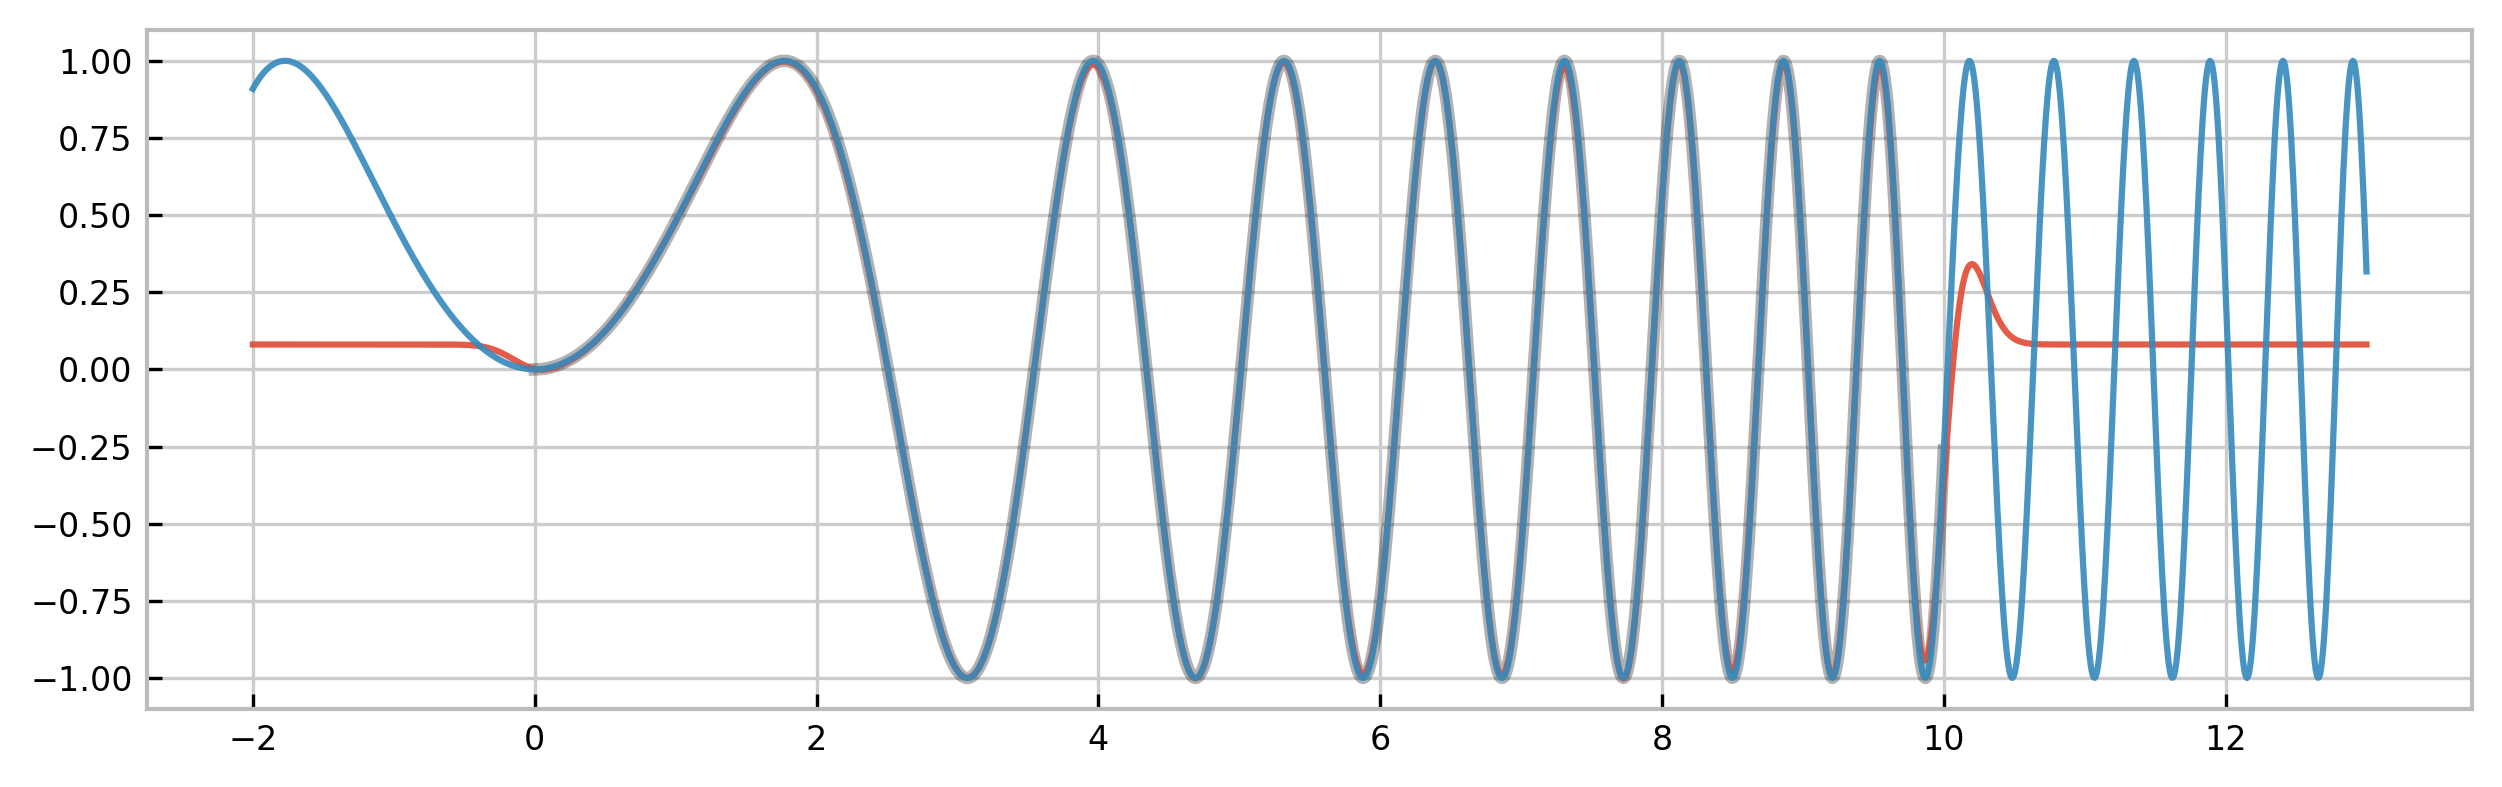

In [9]:
f, ax = plt.subplots(1,1, dpi=300, figsize=(10,3))
ax.plot(train_x[train_x>-20], train_y.detach().numpy()[train_x>-20], 'k', lw=3, alpha=0.3)
ax.plot(test_x, mean.detach().numpy(), alpha=0.9)
ax.plot(test_x, test_y, alpha=0.9)

In [10]:
# Test interpolation error
test_x = torch.linspace(0,10, 2000)
test_y = torch.sin(0.5*test_x**2)
gp.test_innerproduct(test_x, test_y)

0.00021831624

In [18]:
# Test extrapolation error
test_x = torch.linspace(-2,0, 2000)
test_y = torch.sin(0.5*test_x**2)
gp.test_innerproduct(test_x, test_y)

0.86188024

## Chirp-like function

In [19]:
train_x = torch.linspace(0,10, 1000)
train_y = train_x*torch.sin(0.5*train_x**2)

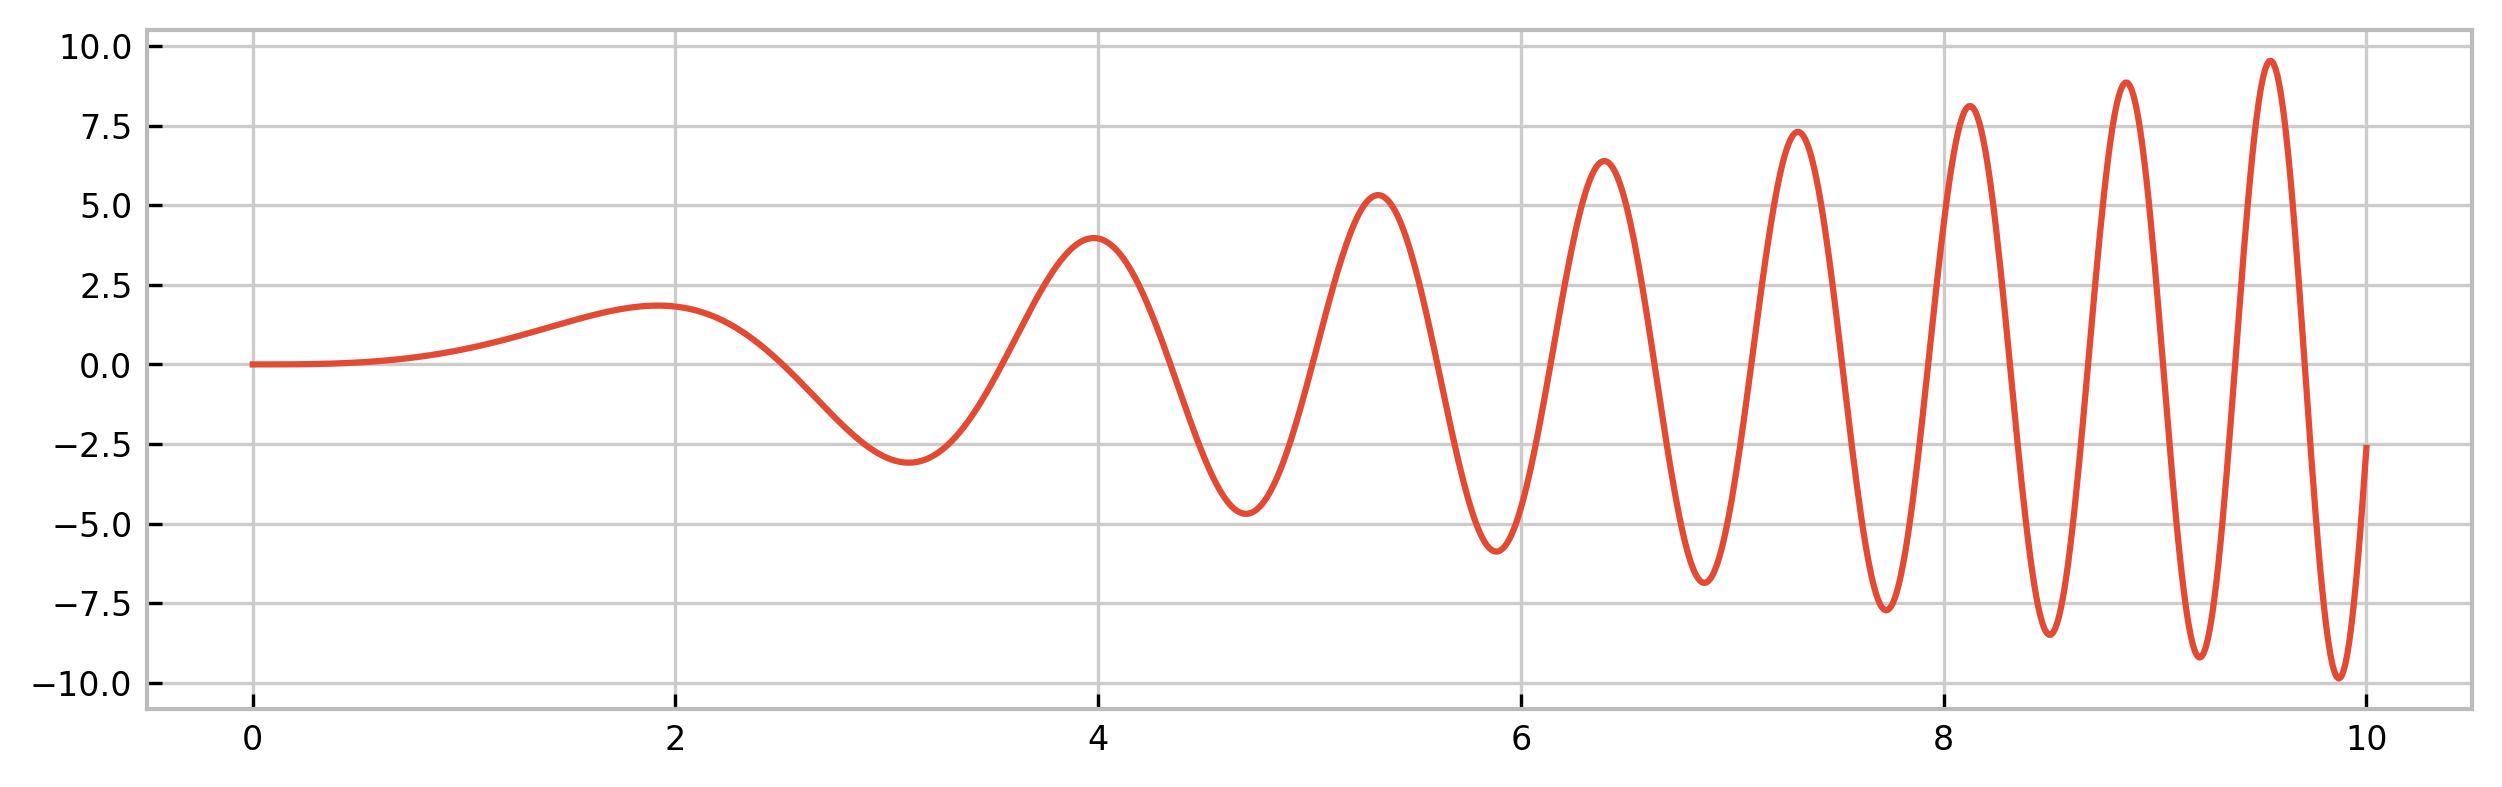

In [20]:
f, ax = plt.subplots(1,1, dpi=300, figsize=(10,3))
ax.plot(train_x, train_y)

Again we can attempt to model this with just the radial basis function.

In [21]:
kernel = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.RBFKernel(lengthscale_constraint=gpytorch.constraints.Interval(0.1, 5)) 
)

In [22]:
gp = GaussianProcessEmulator(kernel, train_x, train_y)
gp.train(500)

/home/daniel/repositories/heron/environment/lib/python3.9/site-packages/gpytorch/utils/linear_cg.py:266: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  _jit_linear_cg_updates_no_precond(


Iter 1/500 - Loss: 33.112  2.550noise: 0.250
Iter 11/500 - Loss: 0.826  0.176noise: 0.486
Iter 21/500 - Loss: 0.828  0.112noise: 0.496
Iter 31/500 - Loss: 0.833  0.106noise: 0.497
Iter 41/500 - Loss: 0.856  0.104noise: 0.498
Iter 51/500 - Loss: 0.843  0.104noise: 0.498
Iter 61/500 - Loss: 0.863  0.104noise: 0.498
Iter 71/500 - Loss: 0.854  0.104noise: 0.498
Iter 81/500 - Loss: 0.854  0.104noise: 0.498
Iter 91/500 - Loss: 0.845  0.104noise: 0.498
Iter 101/500 - Loss: 0.849  0.104noise: 0.498
Iter 111/500 - Loss: 0.848  0.104noise: 0.498
Iter 121/500 - Loss: 0.838  0.104noise: 0.498
Iter 131/500 - Loss: 0.857  0.104noise: 0.498
Iter 141/500 - Loss: 0.857  0.104noise: 0.498
Iter 151/500 - Loss: 0.844  0.104noise: 0.498
Iter 161/500 - Loss: 0.838  0.104noise: 0.498
Iter 171/500 - Loss: 0.851  0.105noise: 0.498
Iter 181/500 - Loss: 0.863  0.105noise: 0.498
Iter 191/500 - Loss: 0.857  0.105noise: 0.498
Iter 201/500 - Loss: 0.851  0.105noise: 0.498
Iter 211/500 - Loss: 0.844  0.105noise: 0.49

In [23]:
test_x = torch.linspace(-1,11, 1500)
test_y = test_x*torch.sin(0.5*test_x**2)
mean, var, bounds = gp.predict(test_x)

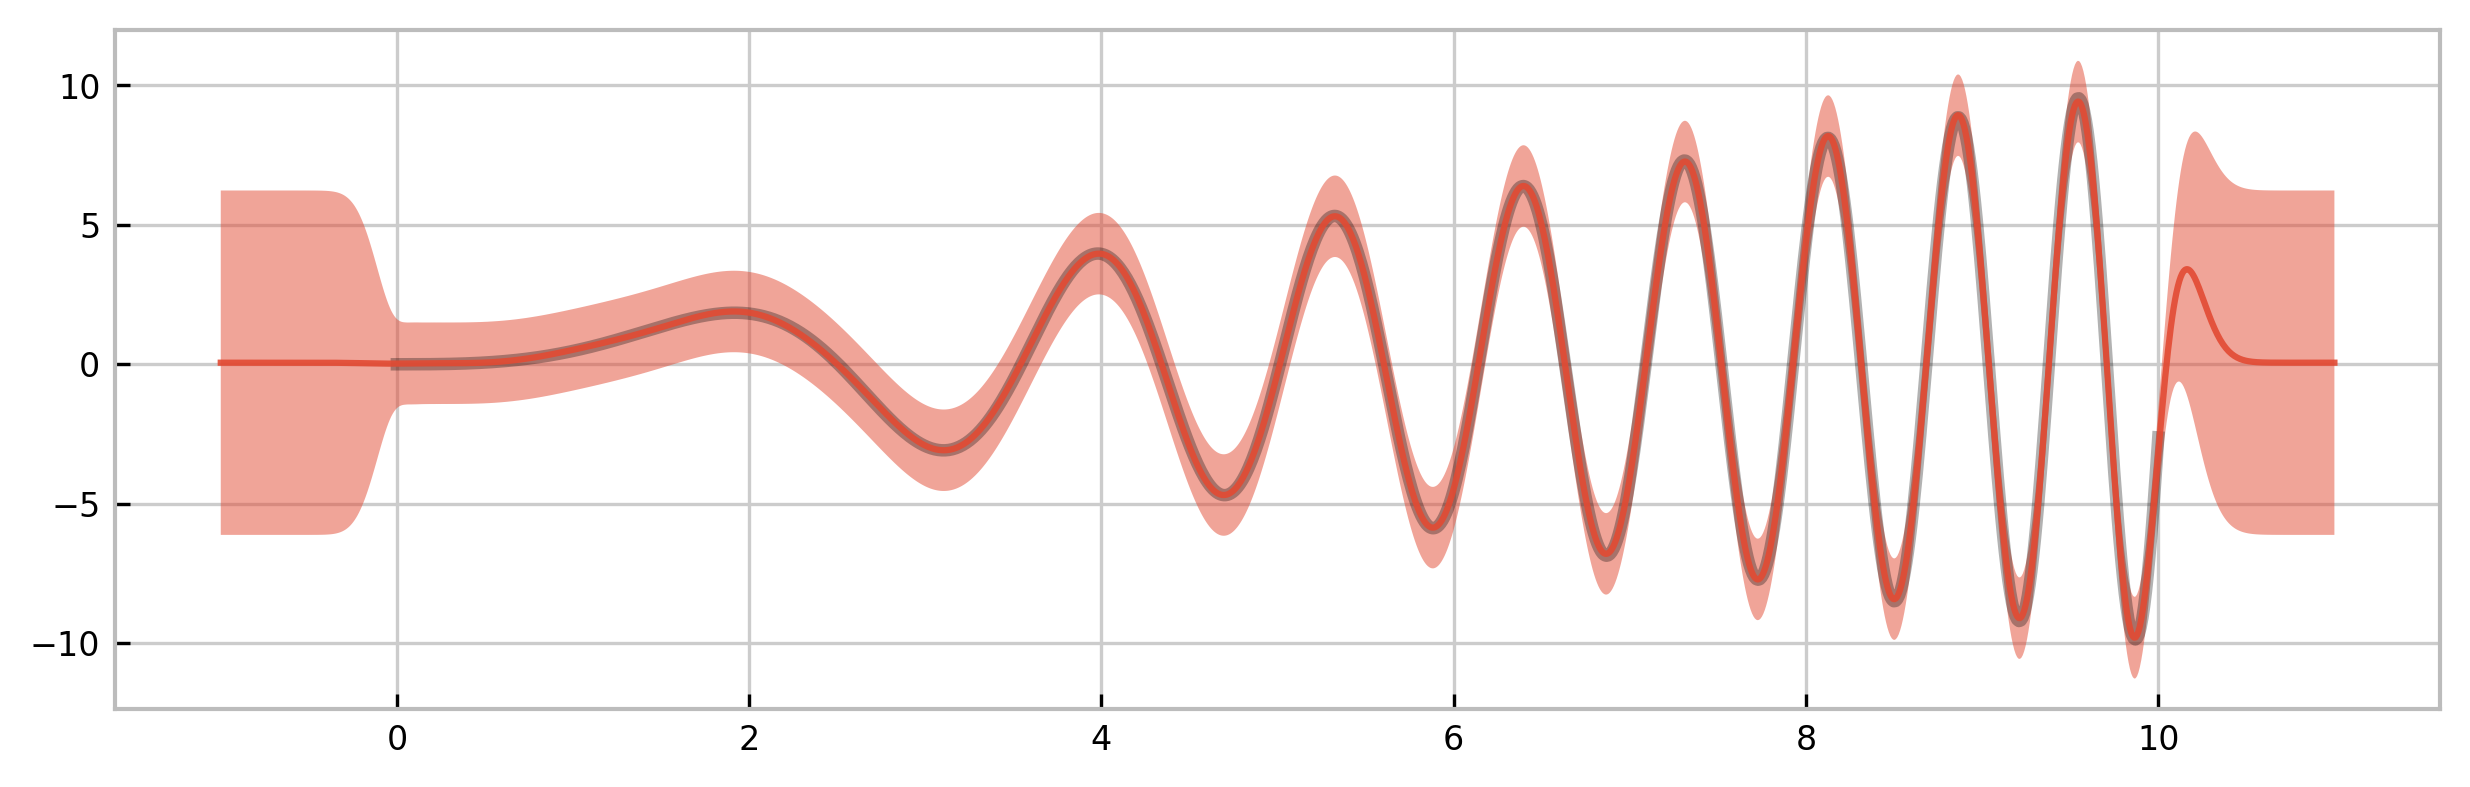

In [24]:
f, ax = plt.subplots(1,1, dpi=300, figsize=(10,3))

upper, lower = bounds.confidence_region()
ax.fill_between(test_x.numpy(), upper.detach().numpy(), lower.detach().numpy(), alpha=0.5)

ax.plot(train_x[train_x>-20], train_y.detach().numpy()[train_x>-20], 'k', lw=3, alpha=0.3)
ax.plot(test_x, mean.detach().numpy(), alpha=0.9)


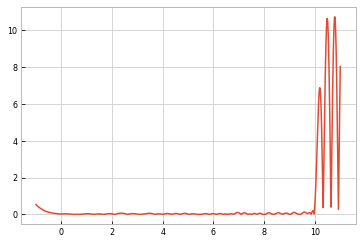

In [26]:
plt.plot(test_x, gp.test_mrse(test_x, test_y))

In [28]:
# Interpolation accuracy
test_x = torch.linspace(0,10, 1500)
test_y = test_x*torch.sin(0.5*test_x**2)
gp.test_innerproduct(test_x, test_y)

0.00014584693

In [29]:
# Extrapolation accuracy
test_x = torch.linspace(-2,0, 1500)
test_y = test_x*torch.sin(0.5*test_x**2)
gp.test_innerproduct(test_x, test_y)

1.0872097

In [34]:
kernel = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.MaternKernel(lengthscale_constraint=gpytorch.constraints.Interval(0.1, 5)) 
)
gp = GaussianProcessEmulator(kernel, train_x, train_y)
gp.train(500)

/home/daniel/repositories/heron/environment/lib/python3.9/site-packages/gpytorch/utils/linear_cg.py:266: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  _jit_linear_cg_updates_no_precond(


Iter 500/500 - Loss: 0.816  0.242noise: 0.485


In [35]:
# Interpolation accuracy
test_x = torch.linspace(0,10, 1500)
test_y = test_x*torch.sin(0.5*test_x**2)
gp.test_innerproduct(test_x, test_y)

0.00018535252

In [36]:
# Extrapolation accuracy
test_x = torch.linspace(-2,0, 1500)
test_y = test_x*torch.sin(0.5*test_x**2)
gp.test_innerproduct(test_x, test_y)

1.0680145

In [37]:
kernel = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel(lengthscale_constraint=gpytorch.constraints.Interval(0.1, 5)) 
)
gp = GaussianProcessEmulator(kernel, train_x, train_y)
gp.train(500)

/home/daniel/repositories/heron/environment/lib/python3.9/site-packages/gpytorch/utils/linear_cg.py:266: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:23.)
  _jit_linear_cg_updates_no_precond(


Iter 500/500 - Loss: 2.511  0.100noise: 0.499
